In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random
import torch

from tqdm.notebook import tqdm
from torch import nn
from collections import deque

import gym

In [2]:
import warnings
warnings.filterwarnings("ignore")

# **NEURAL NETWORKS AND DEEP LEARNING**

---
### A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---

| **Student**             | **Degree**        | **ID**    | **Contact**                               |
|-------------------------|-------------------|-----------|-------------------------------------------|
| _Giacomo Franceschetto_ | _Physics of Data_ | _2053348_ | _giacomo.franceschetto@studenti.unipd.it_ |

# _Homework 3 - Reinforcement Learning_

## Introduction

In this homework we are going to tackle a reinforcement learning (RL) task. RL tasks are characterized by few fundamental elements:
- an agent 
- the environment

The agent can be in different states and perform different actions. Each action allow to the agent to interact with the environment, depending on the state of the agent the outcome of the same action could be different. At each action corresponds a reward (positive or negative or zero). The agent has to reach a goal, several conditions can be setted by the environment, the way of learning process keep goings thanks to the reward sistem that push the agent towards the winning conditions.

But how the agent decide which action to take? One way is to exploit Q-Learning, a method focused on matching a (state, action) couple with the corresponding expected cumulative reward. This process can be pursued through a deep neural network (DQN - Deep Q-Learning Networks).

We will exploit the _gym_ environment from OpenAI that allow us to easily define an environment, our two case of studies will be the CartPole and the MountainCar games.

## Class & Functions definitions

### Experience replay

_A critical component of DQN-style algorithms is experience
replay (Lin, 1992). The experience replay is a fixed-size
buffer that holds the most recent transitions collected by
the policy. It greatly improves the sample efficiency of the
algorithm by enabling data to be reused multiple times for
training, instead of throwing away data immediately after
collection, and also improves the stability of the network
during training._ (Revisiting Fundamentals of Experience Replay, W. Fedus)

As well explained in this paper we make use of a buffer style object to develop experience replay for our model and allow to reuse past data samples multiple times during the training process.


In [3]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))
        
    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

### Policy network

With policy network we mean the deep neural network that allow the agent to make decisions on which actions to take, we implement it as a simple network with one hidden layer of 128 neurons.

In [4]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(in_features=state_space_dim, out_features=128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

### Exploration Policy

Exploration policy consist in understanding what to do with the outcome of our policy network, we have to trade off:
- exploration
- exploitation

Alway choosing the best option helps the process of learning or maybe sometimes is better to _explore_ the landscape and choose a non-optimal action?

We implement two policies:
- Epsilon-greedy policy: choose the optimal action with probability $1-\epsilon$
- Softmax policy: choose the action according to a softmax distribution with temperature $\tau$

#### Epsilon-greedy policy

In [5]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

#### Softmax policy

In [6]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

#### Softmax Exploration profile

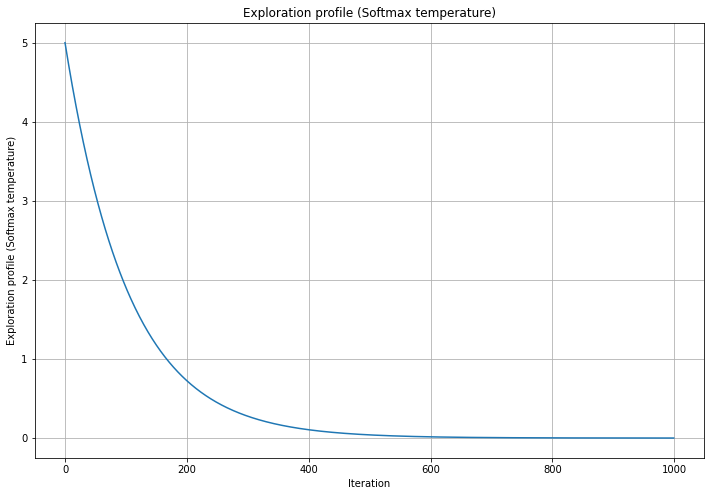

In [7]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.title('Exploration profile (Softmax temperature)')
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')
plt.show()

In [8]:
def softmax_exploration_profile(initial_value=5, num_iterations=1000):
    exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
    exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]
    return exploration_profile

### DQN learning

Here are few functions discussed in class to implement the DQN learning, other than experience replay we notice also the use of a target network. We are not going into the details but, the basic motivation of the target network is to increase the stability of the training during the Q-Learning process.

In [9]:
def setup(par, replay_memory_capacity=10000, state_space_dim=4, action_space_dim=2):

    replay_mem = ReplayMemory(replay_memory_capacity)    
    policy_net = DQN(state_space_dim, action_space_dim)

    # setup the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    optimizer = torch.optim.SGD(policy_net.parameters(), lr=par['lr']) # The optimizer will update ONLY the parameters of the policy network

    # loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn

In [10]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## CartPole

### Description

From the official documentation:

_This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart._

### Action & Observation space

The action space can take values (0, 1), meaning pushing the ca to the left or to the right. The state, observation space, has 4 features, the cart position (-4.8, 4.8), cart velocity, pole ange (-24°, 24°)
, pole angular velocity.

### Reward & Episode End

The goal of the game is to keep the pole upright as long as possible, for each step taken a reward +1 is assigned.
The episode ends either if the :
- pole angle is greater than +-12°
- cart position greater than +-2.4
- episode lenght greater than 500





In [11]:
env = gym.make('CartPole-v1') 
env.seed(0)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f'State space size: {state_space_dim}')
print(f'Action space size: {action_space_dim}')

State space size: 4
Action space size: 2


### Random agent

First we can try to run a random agent on the environment and observe how it behaves

In [12]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed=0 # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      #env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()

EPISODE 1 - FINAL SCORE: 16.0
EPISODE 2 - FINAL SCORE: 27.0
EPISODE 3 - FINAL SCORE: 33.0
EPISODE 4 - FINAL SCORE: 12.0
EPISODE 5 - FINAL SCORE: 19.0
EPISODE 6 - FINAL SCORE: 20.0
EPISODE 7 - FINAL SCORE: 16.0
EPISODE 8 - FINAL SCORE: 12.0
EPISODE 9 - FINAL SCORE: 14.0
EPISODE 10 - FINAL SCORE: 10.0


As expected the agent fails after few steps.

### Training

Very often, what to determine the agent winning or loosing is the strategy implemented throgh the reward system. In this case we have as default only a reward for the pole not falling, in class we noticed the performance improvement adding a penalty for the car going away from the center o the platform, here we add another penalty term that takes in account high angular velocity.

In [13]:
def training_loop(policy_net, target_net, replay_mem, exploration_profile, par, optimizer, loss_fn, verbose=False):

    # Initialize the Gym environment
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)
    
    training_score = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:
            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # We apply a (linear) penalty when the cart is far from center + high angular velocity
            pos_weight = 1
            ang_vel_weight = 0.2
            reward = reward - pos_weight * np.abs(state[0]) - ang_vel_weight * np.abs(state[3])

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += par['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > par['min_samples_for_training']: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, par['gamma'], optimizer, loss_fn, par['batch_size'])

            # Visually render the environment (disable to speed up the training)
            #env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % par['target_net_update_steps'] == 0:
            if verbose:
                print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if verbose:
            print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature : {tau}") # Print the final score
    
        training_score.append(score)
        
    env.close()
    
    return policy_net, training_score

We perform a random grid search over the following parameters:
- _gamma_ : parameter for the long term award
- _learning rate_
- _initial value_ : initial value of the softmax exploration profile
- number of steps needed to update the target network (avoiding catastrophic forgetting)

In [49]:
N = 10

parameters_list = []
scores_list = []
expl_profiles_list = []

# random sweep over the following parameters
gamma_list = np.linspace(0.9, 0.99, 10)
lr_list = np.logspace(-2, -1, 10)
update_steps_list = np.linspace(5, 16).astype(int)


for i in range(N):
    # compute exploration profile
    ## sort initial value
    initial_value = np.random.randint(2, 8)
    exploration_profile = softmax_exploration_profile(initial_value)

    params = {'gamma':                   np.random.choice(gamma_list),
              'min_samples_for_training': 1000,
              'batch_size':              128,
              'target_net_update_steps': np.random.choice(update_steps_list),
              'bad_state_penalty':       0,
              'lr':                      np.random.choice(lr_list)
             }
    
    print('Trial {}'.format(i+1))
    print('Parameters list {}'.format(params))

    replay_mem, policy_net, target_net, optimizer, loss_fn = setup(params)

    policy_net, training_score = training_loop(policy_net, 
                                               target_net, 
                                               replay_mem, 
                                               exploration_profile, 
                                               params, 
                                               optimizer,
                                               loss_fn, 
                                               verbose = False)
    
    parameters_list.append(params)
    scores_list.append(training_score)
    expl_profiles_list.append(exploration_profile)

Trial 1
Parameters list {'gamma': 0.93, 'min_samples_for_training': 1000, 'batch_size': 128, 'target_net_update_steps': 10, 'bad_state_penalty': 0, 'lr': 0.01291549665014884}


  0%|          | 0/1000 [00:00<?, ?it/s]

Trial 2
Parameters list {'gamma': 0.97, 'min_samples_for_training': 1000, 'batch_size': 128, 'target_net_update_steps': 6, 'bad_state_penalty': 0, 'lr': 0.027825594022071243}


  0%|          | 0/1000 [00:00<?, ?it/s]

Trial 3
Parameters list {'gamma': 0.91, 'min_samples_for_training': 1000, 'batch_size': 128, 'target_net_update_steps': 13, 'bad_state_penalty': 0, 'lr': 0.016681005372000592}


  0%|          | 0/1000 [00:00<?, ?it/s]

Trial 4
Parameters list {'gamma': 0.99, 'min_samples_for_training': 1000, 'batch_size': 128, 'target_net_update_steps': 9, 'bad_state_penalty': 0, 'lr': 0.05994842503189409}


  0%|          | 0/1000 [00:00<?, ?it/s]

Trial 5
Parameters list {'gamma': 0.98, 'min_samples_for_training': 1000, 'batch_size': 128, 'target_net_update_steps': 9, 'bad_state_penalty': 0, 'lr': 0.01291549665014884}


  0%|          | 0/1000 [00:00<?, ?it/s]

Trial 6
Parameters list {'gamma': 0.97, 'min_samples_for_training': 1000, 'batch_size': 128, 'target_net_update_steps': 8, 'bad_state_penalty': 0, 'lr': 0.01291549665014884}


  0%|          | 0/1000 [00:00<?, ?it/s]

Trial 7
Parameters list {'gamma': 0.98, 'min_samples_for_training': 1000, 'batch_size': 128, 'target_net_update_steps': 13, 'bad_state_penalty': 0, 'lr': 0.01291549665014884}


  0%|          | 0/1000 [00:00<?, ?it/s]

Trial 8
Parameters list {'gamma': 0.93, 'min_samples_for_training': 1000, 'batch_size': 128, 'target_net_update_steps': 9, 'bad_state_penalty': 0, 'lr': 0.046415888336127774}


  0%|          | 0/1000 [00:00<?, ?it/s]

Trial 9
Parameters list {'gamma': 0.96, 'min_samples_for_training': 1000, 'batch_size': 128, 'target_net_update_steps': 13, 'bad_state_penalty': 0, 'lr': 0.046415888336127774}


  0%|          | 0/1000 [00:00<?, ?it/s]

Trial 10
Parameters list {'gamma': 0.99, 'min_samples_for_training': 1000, 'batch_size': 128, 'target_net_update_steps': 5, 'bad_state_penalty': 0, 'lr': 0.016681005372000592}


  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
def rolling_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

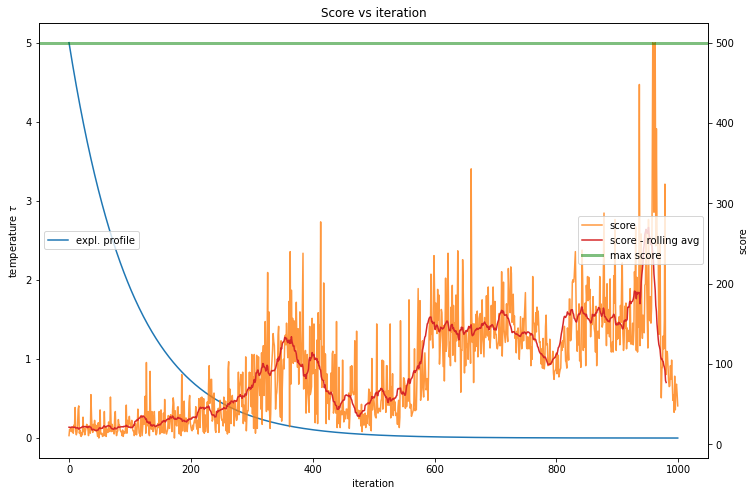

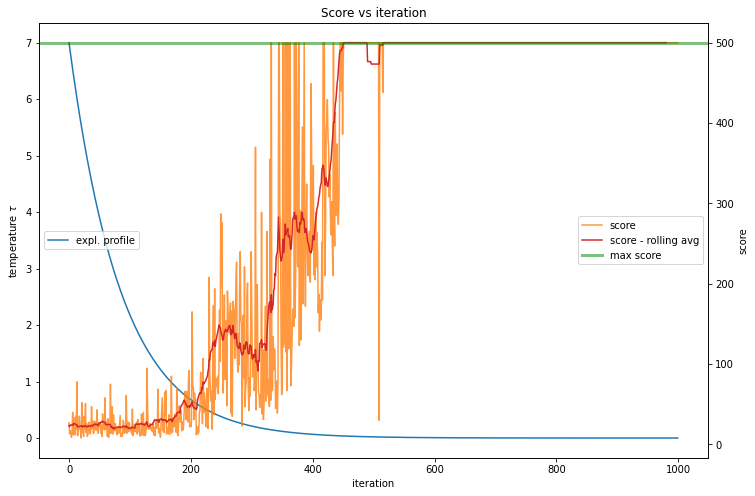

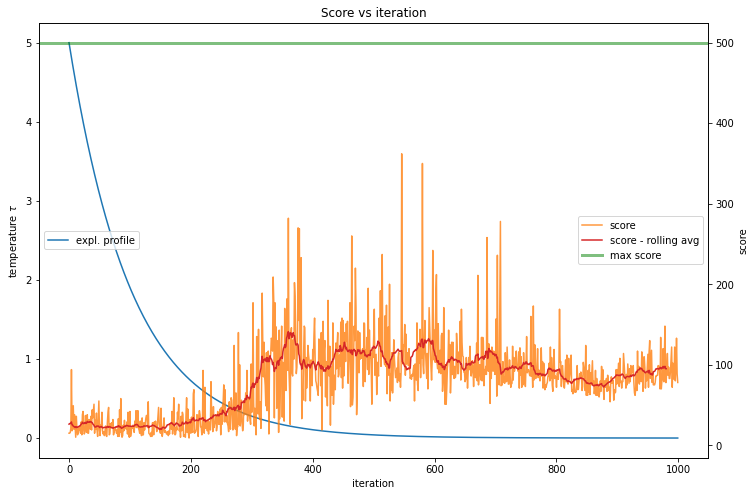

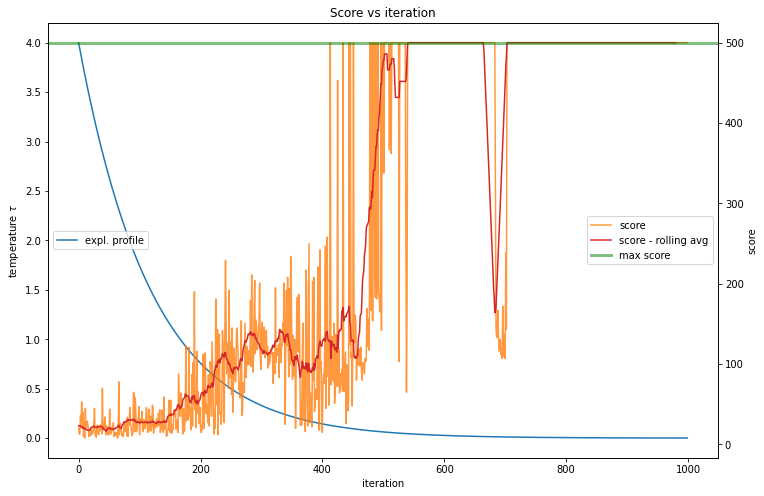

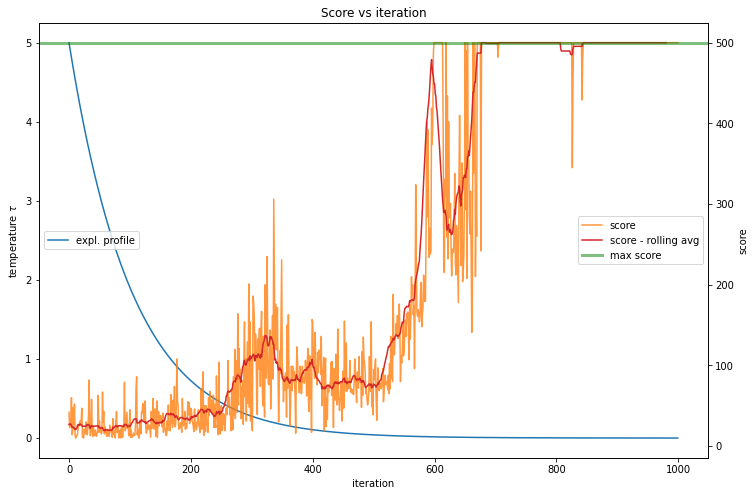

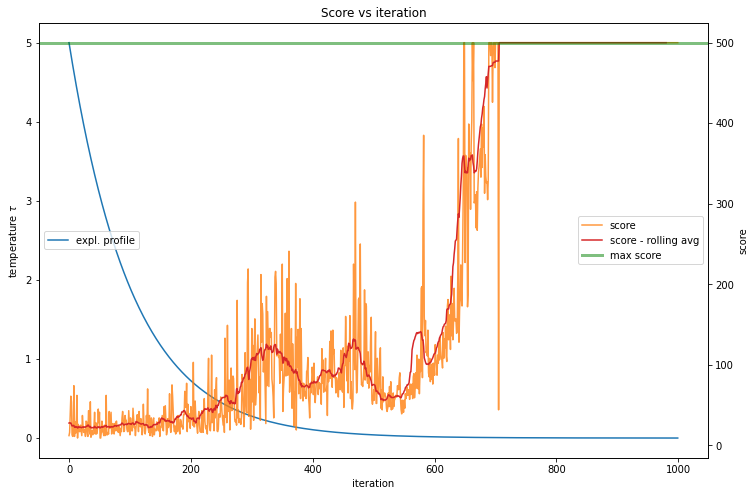

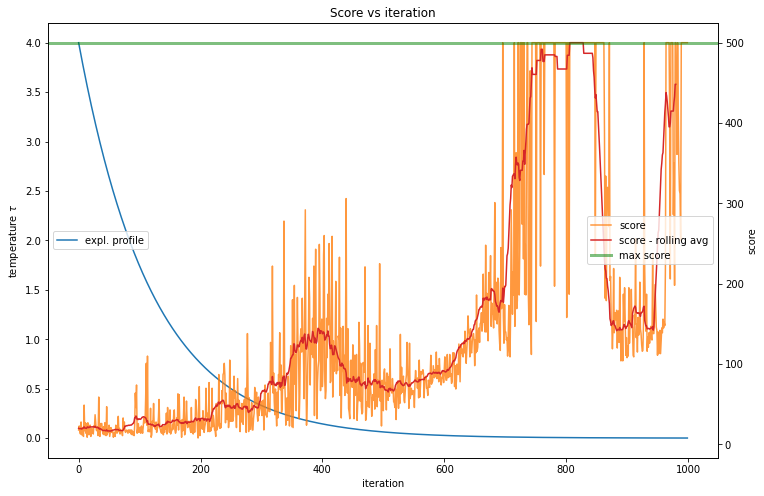

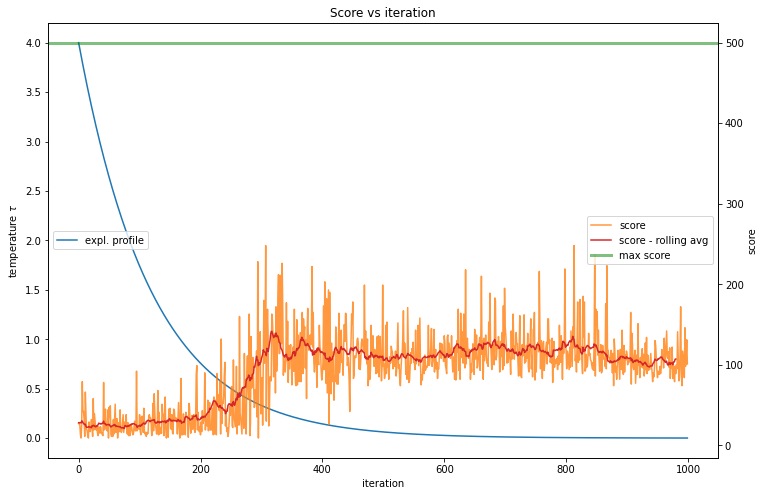

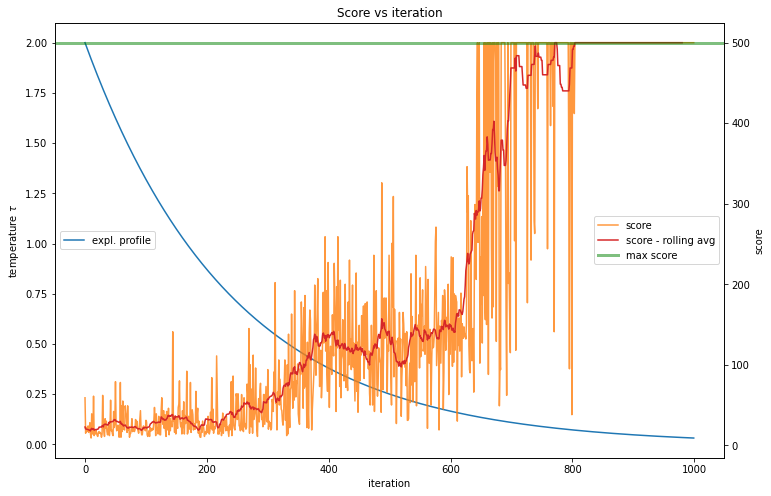

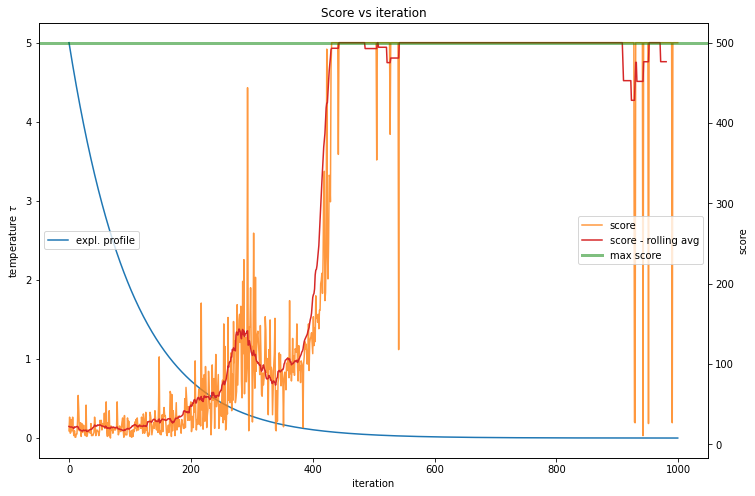

In [51]:
x = np.arange(0,1000,1)

for i in range(N):   

    fig, ax1 = plt.subplots(figsize=(12,8))
    ax2 = ax1.twinx()
    
    ax2.plot(scores_list[i], c='tab:orange', alpha=0.8, label = 'score')
    ax1.plot(expl_profiles_list[i], c='tab:blue', label='expl. profile')
    ax2.plot(rolling_average(scores_list[i],20), c='tab:red', label= 'score - rolling avg')
    
    ax1.set_xlabel('iteration')
    ax1.set_ylabel(r'temperature $\tau$')

    ax2.set_ylabel('score')  
    
    ax2.axhline(500, color='green', lw=3, alpha=0.5, label='max score')
    ax1.legend(loc='center left')
    ax2.legend(loc='center right')
    plt.title('Score vs iteration')
    
    plt.show()

From this grid search we can make some observations about how the exploration profile combined with the DQN learning method parameters impact the learning curve:
- high initial values for the softmax policy increase exploration and allows the model to learn faster
- low initial values for the softmax policy with a low gamma parameter for the long term award fail to achieve the goal, neither exploration or long term expected reward consideration are exploited
- low initial values for the softmax policy with high value for the gamma parameter allow to learn to achieve the task, a bit slower than the first case but anyway in a succsessfull way.

We pick the best model considering a costum score that takes in account both the average score since the first win and the time-step of the first win:

In [58]:
# compute average score starting from the iteration when max score is reached
max_score = 500
costume_score = []
for i in range(N):
    costume_score.append(np.mean(rolling_average(scores_list[i],20)[np.argmax(rolling_average(scores_list[i],20)):])*1000/np.argmax(rolling_average(scores_list[i],20)))

In [73]:
best_params = parameters_list[np.argmax(costume_score)]

In [74]:
best_expl_profile = expl_profiles_list[np.argmax(costume_score)]

#### Train the best model

In [78]:
replay_mem, policy_net, target_net, optimizer, loss_fn = setup(best_params)
policy_net, training_score = training_loop( policy_net,
                                            target_net,
                                            replay_mem,
                                            best_expl_profile,
                                            best_params,
                                            optimizer,
                                            loss_fn,
                                            verbose = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 16 - Temperature : 5.0
EPISODE: 2 - FINAL SCORE: 14 - Temperature : 4.951949240166454
EPISODE: 3 - FINAL SCORE: 12 - Temperature : 4.904360255437024
EPISODE: 4 - FINAL SCORE: 16 - Temperature : 4.857228608082785
EPISODE: 5 - FINAL SCORE: 13 - Temperature : 4.810549903022062
Updating target network...
EPISODE: 6 - FINAL SCORE: 22 - Temperature : 4.764319787410582
EPISODE: 7 - FINAL SCORE: 16 - Temperature : 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 11 - Temperature : 4.673188121913726
EPISODE: 9 - FINAL SCORE: 14 - Temperature : 4.628278073893115
EPISODE: 10 - FINAL SCORE: 26 - Temperature : 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 21 - Temperature : 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 20 - Temperature : 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 28 - Temperature : 4.452912527905132
EPISODE: 14 - FINAL SCORE: 62 - Temperature : 4.4101193618175
EPISODE: 15 - FINAL SCORE: 107 - Temperature 

With the trained best model we can see what happens if we impose to always choose the best action

In [86]:
# Initialize the Gym environment
env = gym.make('CartPole-v1')
env.seed(0)

# Total of 10 episodes
for num_episode in tqdm(range(10)): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    
    while not done:
        with torch.no_grad():
            action = int(policy_net(torch.tensor(state, dtype=torch.float32)).argmax())

        # Apply the action and get the next state, the reward and a flag 'done' that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        state = next_state
    
    # Print the final score
    print(f'EPISODE {num_episode + 1} - FINAL SCORE: {score}') 
env.close() 

  0%|          | 0/10 [00:00<?, ?it/s]

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


Always choosing the best action with the best model means always winning, the task is solved and the model has learned how to play the game.

## Mountaincar

We are going now to explore a different environment and train another RL model, the environment we are talking about is again taken from the OpenAI gym documentation

### Description

_The Mountain Car Markov Decision Process is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill._

### Action & Observation space

The agent can take three actions, accelerate to the left (0), don't accelerate (1) or accelerate to the right (2).

The observation space contain the following features:
- position of the car along the x axis
- velocity of the car

### Rewards & Episode End

The goal of the game is to reach the flag placed in top of the right hill, each timestep when the goal is not reached is penalised with a reward -1.

The episode ends if the car reaches position 0.5 or if the time-step 200 is reached.




## Environment

In [10]:
env = gym.make('MountainCar-v0') 
env.seed(0)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f'State space size: {state_space_dim}')
print(f'Action space size: {action_space_dim}')

State space size: 2
Action space size: 3


### Training loop

As stated before, is fundamental to proper select the reward to increase the probablity of the agent learning the task.

We can try a first training loop without tuning the reward function.

In [11]:
def training_loop(policy_net, target_net, replay_mem, exploration_profile, par, optimizer, loss_fn, verbose=False):

    # Initialize the Gym environment
    env = gym.make('MountainCar-v0') 
    env.seed(0) # Set a random seed for the environment (reproducible results)
    
    training_score = []
    max_positions_reached = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False
        max_position = state[0]

        # Go on until the the car reaches 0.5 or maximum number of steps is reached
        while not done:
            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # Update the final score 
            score += reward

            # store maximum reached position
            if next_state[0]>max_position: max_position = next_state[0]

            # Apply penalty for bad state
            if done: 
                reward += par['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > par['min_samples_for_training']: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, par['gamma'], optimizer, loss_fn, par['batch_size'])

            # Visually render the environment (disable to speed up the training)
            #env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % par['target_net_update_steps'] == 0:
            if verbose:
                print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if verbose:
            print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - max position: {round(max_position, 2)} - Temperature : {round(tau, 2)}") # Print the final score
    
        training_score.append(score)
        max_positions_reached.append(max_position)
        
    env.close()
    
    return policy_net, max_positions_reached, training_score

In [12]:
params = {
    'gamma': 0.98,
    'min_samples_for_training': 1000,
    'batch_size': 64,
    'target_net_update_steps': 5,
    'bad_state_penalty': 0,
    'lr': 0.01
    }

In [13]:
initial_value = 5
exploration_profile = softmax_exploration_profile(initial_value)

In [14]:
replay_mem, policy_net, target_net, optimizer, loss_fn = setup(params, state_space_dim=state_space_dim, action_space_dim=action_space_dim)
policy_net, max_position, training_score = training_loop( policy_net,
                                            target_net,
                                            replay_mem,
                                            exploration_profile,
                                            params,
                                            optimizer,
                                            loss_fn,
                                            verbose = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -200.0 - max position: -0.4699999988079071 - Temperature : 5.0
EPISODE: 2 - FINAL SCORE: -200.0 - max position: -0.28999999165534973 - Temperature : 4.95
EPISODE: 3 - FINAL SCORE: -200.0 - max position: -0.44999998807907104 - Temperature : 4.9
EPISODE: 4 - FINAL SCORE: -200.0 - max position: -0.3799999952316284 - Temperature : 4.86
EPISODE: 5 - FINAL SCORE: -200.0 - max position: -0.4699999988079071 - Temperature : 4.81
Updating target network...
EPISODE: 6 - FINAL SCORE: -200.0 - max position: -0.3799999952316284 - Temperature : 4.76
EPISODE: 7 - FINAL SCORE: -200.0 - max position: -0.44999998807907104 - Temperature : 4.72
EPISODE: 8 - FINAL SCORE: -200.0 - max position: -0.44999998807907104 - Temperature : 4.67
EPISODE: 9 - FINAL SCORE: -200.0 - max position: -0.44999998807907104 - Temperature : 4.63
EPISODE: 10 - FINAL SCORE: -200.0 - max position: -0.46000000834465027 - Temperature : 4.58
Updating target network...
EPISODE: 11 - 

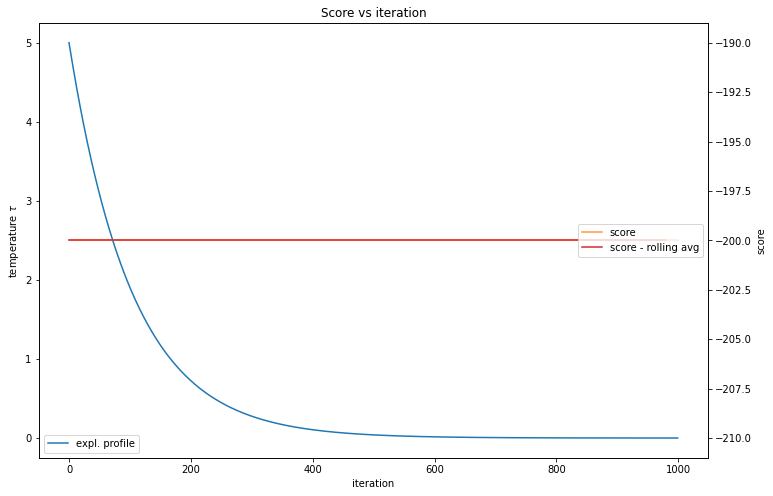

In [21]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()

ax2.plot(training_score, c='tab:orange', alpha=0.8, label = 'score')
ax1.plot(exploration_profile, c='tab:blue', label='expl. profile')
ax2.plot(rolling_average(training_score,20), c='tab:red', label= 'score - rolling avg')

ax1.set_xlabel('iteration')
ax1.set_ylabel(r'temperature $\tau$')

ax2.set_ylabel('score')  

ax1.legend(loc='lower left')
ax2.legend(loc='center right')
plt.title('Score vs iteration')
plt.show()

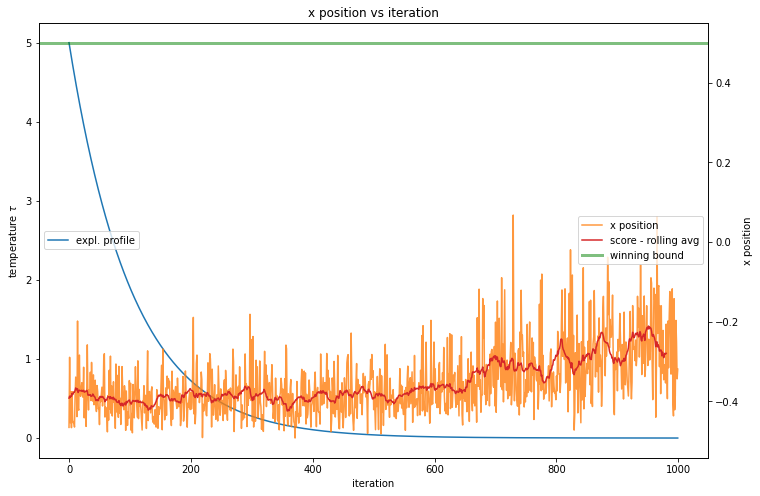

In [19]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()

ax2.plot(max_position, c='tab:orange', alpha=0.8, label = 'x position')
ax1.plot(exploration_profile, c='tab:blue', label='expl. profile')
ax2.plot(rolling_average(max_position,20), c='tab:red', label= 'score - rolling avg')

ax1.set_xlabel('iteration')
ax1.set_ylabel(r'temperature $\tau$')

ax2.axhline(0.5, color='green', lw=3, alpha=0.5, label='winning bound')

ax2.set_ylabel('x position')  

ax1.legend(loc='center left')
ax2.legend(loc='center right')
plt.title('x position vs iteration')
plt.show()

It is clear that the agent has not learned how to solve the game, the score is always at value -200 and that means that over all the episodes the agent never won. This is clear also if we look at the position vs iteration plot.

A simple idea to tune the reward function is to help the car getting some momentum, swinging along the platform will eventually bring to the win position. Indeed, we assign a reward +1 when the car is moving left and accelerating left or moving right and accelerating right.

In [26]:
def training_loop(policy_net, target_net, replay_mem, exploration_profile, par, optimizer, loss_fn, verbose=False):

    # Initialize the Gym environment
    env = gym.make(''MountainCar-v0') 
    env.seed(0) # Set a random seed for the environment (reproducible results)
    
    training_score = []
    max_positions_reached = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False
        max_position = state[0]

        # Go on until the the car reaches 0.5 or maximum number of steps is reached
        while not done:
            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # increase reward if the momentum of the car is increasing
            if next_state[0] - state[0] > 0 and action == 2: reward += 1
            if next_state[0] - state[0] < 0 and action == 0: reward += 1
            if next_state[0] >= 0.5: reward += 1

            # Update the final score 
            score += reward

            # store maximum reached position
            if next_state[0]>max_position: max_position = next_state[0]

            # Apply penalty for bad state
            if done: 
                reward += par['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > par['min_samples_for_training']: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, par['gamma'], optimizer, loss_fn, par['batch_size'])

            # Visually render the environment (disable to speed up the training)
            #env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % par['target_net_update_steps'] == 0:
            if verbose:
                print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if verbose:
            print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - max position: {round(max_position, 2)} - Temperature : {round(tau, 2)}") # Print the final score
    
        training_score.append(score)
        max_positions_reached.append(max_position)
        
    env.close()
    
    return policy_net, max_positions_reached, training_score

In [27]:
params = {
    'gamma': 0.98,
    'min_samples_for_training': 1000,
    'batch_size': 64,
    'target_net_update_steps': 5,
    'bad_state_penalty': 0,
    'lr': 0.01
    }

In [28]:
initial_value = 5
exploration_profile = softmax_exploration_profile(initial_value)

In [31]:
replay_mem, policy_net, target_net, optimizer, loss_fn = setup(params, state_space_dim=state_space_dim, action_space_dim=action_space_dim)
policy_net, max_position, training_score = training_loop( policy_net,
                                            target_net,
                                            replay_mem,
                                            exploration_profile,
                                            params,
                                            optimizer,
                                            loss_fn,
                                            verbose = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -120.0 - max position: -0.36000001430511475 - Temperature : 5.0
EPISODE: 2 - FINAL SCORE: -125.0 - max position: -0.28999999165534973 - Temperature : 4.95
EPISODE: 3 - FINAL SCORE: -126.0 - max position: -0.4099999964237213 - Temperature : 4.9
EPISODE: 4 - FINAL SCORE: -119.0 - max position: -0.20999999344348907 - Temperature : 4.86
EPISODE: 5 - FINAL SCORE: -121.0 - max position: -0.25999999046325684 - Temperature : 4.81
Updating target network...
EPISODE: 6 - FINAL SCORE: -125.0 - max position: -0.41999998688697815 - Temperature : 4.76
EPISODE: 7 - FINAL SCORE: -111.0 - max position: -0.49000000953674316 - Temperature : 4.72
EPISODE: 8 - FINAL SCORE: -122.0 - max position: -0.36000001430511475 - Temperature : 4.67
EPISODE: 9 - FINAL SCORE: -129.0 - max position: -0.4000000059604645 - Temperature : 4.63
EPISODE: 10 - FINAL SCORE: -127.0 - max position: -0.38999998569488525 - Temperature : 4.58
Updating target network...
EPISODE: 11 

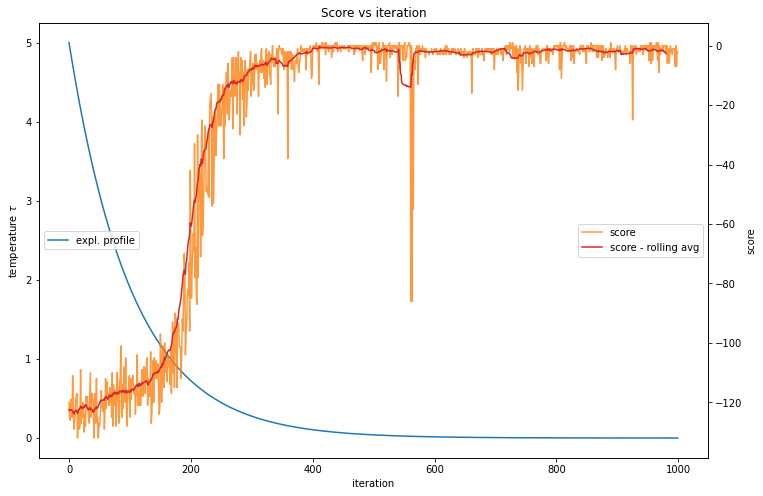

In [35]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()

ax2.plot(training_score, c='tab:orange', alpha=0.8, label = 'score')
ax1.plot(exploration_profile, c='tab:blue', label='expl. profile')
ax2.plot(rolling_average(training_score,20), c='tab:red', label= 'score - rolling avg')

ax1.set_xlabel('iteration')
ax1.set_ylabel(r'temperature $\tau$')

ax2.set_ylabel('score')  

ax1.legend(loc='center left')
ax2.legend(loc='center right')
plt.title('Score vs iteration')
plt.show()

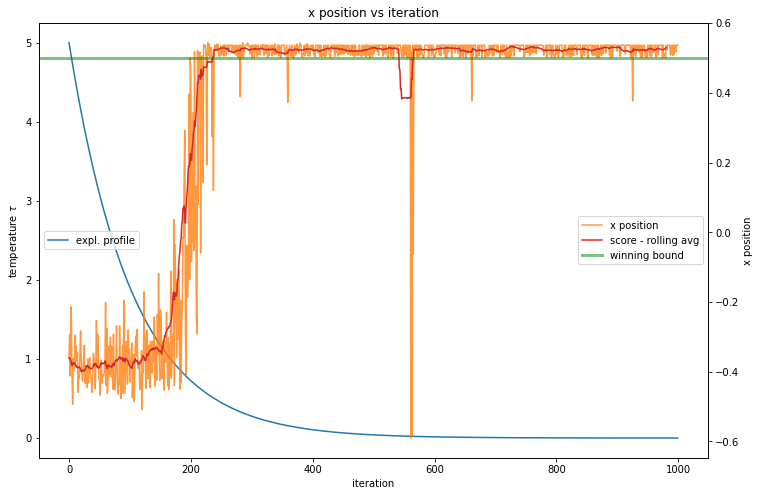

In [39]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()

ax2.plot(max_position, c='tab:orange', alpha=0.8, label = 'x position')
ax1.plot(exploration_profile, c='tab:blue', label='expl. profile')
ax2.plot(rolling_average(max_position,20), c='tab:red', label= 'score - rolling avg')

ax1.set_xlabel('iteration')
ax1.set_ylabel(r'temperature $\tau$')

ax2.axhline(0.5, color='green', lw=3, alpha=0.5, label='winning bound')

ax2.set_ylabel('x position')  

ax1.legend(loc='center left')
ax2.legend(loc='center right')
plt.title('x position vs iteration')
plt.show()

The improvement is evident, after a few iteration the agent already learnt how to solve the task and keep winning for the next iterations.

As before we try to test the trained agent with a 0 epsilon greedy policy.

In [41]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0')
env.seed(0)

# Total of 10 episodes
for num_episode in tqdm(range(10)): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    steps = 0
    
    while not done:
        with torch.no_grad():
            action = int(policy_net(torch.tensor(state, dtype=torch.float32)).argmax())

        # Apply the action and get the next state, the reward and a flag 'done' that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        state = next_state

        steps+=1
    
    print(f'EPISODE {num_episode + 1} - Steps: {steps}') 

  0%|          | 0/10 [00:00<?, ?it/s]

EPISODE 1 - Steps: 152
EPISODE 2 - Steps: 84
EPISODE 3 - Steps: 101
EPISODE 4 - Steps: 151
EPISODE 5 - Steps: 151
EPISODE 6 - Steps: 96
EPISODE 7 - Steps: 152
EPISODE 8 - Steps: 96
EPISODE 9 - Steps: 151
EPISODE 10 - Steps: 160


As expected the agent has always won as the steps are lower than the truncation value 200.